In [ ]:
# submission : https://www.kaggle.com/competitions/ml-2017fall-hw4/leaderboard?tab=public

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd ./drive/MyDrive/NTU_ML2017_Hung-yi-Lee_HW/HW4

[Errno 2] No such file or directory: './drive/MyDrive/NTU_ML2017_Hung-yi-Lee_HW/HW4'
/content/drive/MyDrive/NTU_ML2017_Hung-yi-Lee_HW/HW4


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import csv
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence


In [ ]:
def train_label_data_slice_words(file_name):
  train_label_x = []
  train_label_y = []
  with open(file_name,"r") as file: # encoding?
    for line in file:
      label, content = line.split("+++$+++")
      train_label_x.append(content.split(" "))
      train_label_y.append(float(label))

  return train_label_x, train_label_y


def train_unlabel_data_slice_words(file_name):
  train_unlabel_x = []
  with open(file_name,"r") as file: # encoding?
    for line in file:
      train_unlabel_x.append(line.split(" "))

  return train_unlabel_x


def test_data_slice_words(file_name):
  test_x = []
  with open(file_name,"r") as file: # encoding?
    csv_reader = csv.reader(file)
    next(csv_reader)
    for seg_line in csv_reader:
      test_x.append(seg_line[1].split(" "))

  return test_x

def word_to_wordvector(sentence_list, word_vector_model):
  # print(sentence_list)
  sentence_list_word_vector = []
  for sentence in sentence_list:
    for word in sentence:
      if(not word in word_vector_model.wv.key_to_index):
        print(f"{word} no word vector")

    sentence_list_word_vector.append(torch.tensor([word_vector_model.wv[word] for word in sentence]))

  sentence_list_word_vector = pad_sequence(sentence_list_word_vector, batch_first=True, padding_value=0) # 使用 padding 時 要用 list 包裹 torch-tensor

  # print(len(sentence_list_word_vector))
  # for sentence in sentence_list_word_vector:
  #   for word_vector in sentence:
  #     # if len(word_vector) == word_vector_size:
  #     print(len(word_vector))

  sentence_list_word_vector = np.array(sentence_list_word_vector)

  return sentence_list_word_vector

In [ ]:
train_label_x, train_label_y = train_label_data_slice_words("./data/training_label.txt")
train_unlabel_x = train_unlabel_data_slice_words("./data/training_nolabel.txt")
test_x = test_data_slice_words("./data/testing_data.txt")

print(train_label_x[1][:10])
print(train_label_y[:10])
print(train_unlabel_x[:1][:10])
print(test_x[1][:10])

print(len(train_label_x))
print(len(train_unlabel_x))
print(len(test_x))

['', 'leavingg', 'to', 'wait', 'for', 'kaysie', 'to', 'arrive', 'myspacin', 'itt']
[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0]
[['mkhang', 'mlbo', '.', 'dami', 'niang', 'followers', 'ee', '.', 'di', 'q', 'rin', 'naman', 'sia', 'masisisi', '.', 'desperate', 'n', 'kng', 'desperate', ',', 'pero', 'dpt', 'tlga', 'replyn', 'nia', 'q', '=', 'd\n']]
['omg', 'last', 'day', 'sooon', 'n', 'of', 'primary', 'noooooo', 'x', 'im']
200000
1178614
200000


In [ ]:
train_label_x = train_label_x[:20000]
train_label_y = train_label_y[:20000]
train_unlabel_x = train_unlabel_x[:20000]
test_x = test_x[:2000]

print(len(train_label_x))
print(len(train_unlabel_x))
print(len(test_x))

20000
20000
2000


In [ ]:
word_vector_size = 150 #@param {type: "integer"}

In [ ]:
from gensim.models import Word2Vec

# word_embedding_train_x = train_label_x
word_embedding_train_x = train_label_x + train_unlabel_x + test_x


wordvector_model = Word2Vec(word_embedding_train_x, vector_size=150, window=11, min_count=1, workers=4,sg=1)

In [ ]:
train_label_x_np = word_to_wordvector(train_label_x, wordvector_model)
train_label_y_np = np.array(train_label_y)
# train_unlabel_x_np = word_to_wordvector(train_unlabel_x, model)
# test_x_np = word_to_wordvector(test_x_np, model)


validation_rate = 0.2
validation_index = int(math.floor(train_label_x_np.shape[0] * validation_rate))

val_label_x_np = train_label_x_np[:validation_index]
val_label_y_np = train_label_y_np[:validation_index]
train_label_x_np = train_label_x_np[validation_index:]
train_label_y_np = train_label_y_np[validation_index:]


print(val_label_x_np.shape)
print(val_label_y_np.shape)
print(train_label_x_np.shape)
print(train_label_y_np.shape)


(4000, 40, 150)
(4000,)
(16000, 40, 150)
(16000,)


In [ ]:
print(type(train_label_x_np))
print(type(train_label_y_np))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
class LabeledMessageData(Dataset):
  def __init__(self,x,y):
    self.x = x
    self.y = y

  def __getitem__(self,idx):
    return self.x[idx], self.y[idx]

  def __len__(self):
    return self.x.shape[0]

class UnlabeledMessageData(Dataset):
  def __init__(self,x):
    self.x = x

  def __getitem__(self,idx):
    return self.x[idx]

  def __len__(self):
    return self.x.shape[0]

In [ ]:
train_label_data = LabeledMessageData(train_label_x_np, train_label_y_np)
# train_unlabel_data = UnlabeledMessageData(train_unlabel_x)
# test_data = UnlabeledMessageData(test_x)
val_data = LabeledMessageData(val_label_x_np, val_label_y_np)

train_label_dataloader = DataLoader(train_label_data, batch_size=128, shuffle=True)
# train_unlabel_dataloader = DataLoader(train_unlabel_data, batch_size=128, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=128, shuffle=False)
val_dataloader = DataLoader(val_data, batch_size=128, shuffle=False)



In [ ]:
class SentimentModel(nn.Module):
  def __init__(self,lstm_module_num,lstm_layer_num):
    super(SentimentModel, self).__init__()
    self.lstm = nn.LSTM(input_size=word_vector_size, hidden_size= lstm_module_num, num_layers=lstm_layer_num, batch_first=True) # lstm 需要吃等長的向量
    self.linear = nn.Linear(lstm_module_num,1)
    self.softmax = nn.Softmax()
    self.sigmoid  = nn.Sigmoid()


  def forward(self, x):
    output, (last_output, last_memory) = self.lstm(x)
    l1 = self.linear(last_output[-1,:,:])
    # softmax_output = self.softmax(l1)
    sigmoid_output = self.sigmoid(l1)
    # return softmax_output
    return sigmoid_output

In [ ]:
epoch = 5 #@param {type: "integer"}

learning_rate = 0.1 #@param {type:"number"}

optim_method = "sgd" #@param ["sgd","adam","rms"]

In [ ]:
model = SentimentModel(64,2)
model.to("cpu")

loss_function = nn.CrossEntropyLoss()
if optim_method == "sgd":
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
elif optim_method == "adam":
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
elif optim_method == "rms":
  optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.7)
else:
  raise Exception("no such optimizer")

In [ ]:

#train

train_total_loss = []
train_total_acc = []
val_total_loss = []
val_total_acc = []

for i in tqdm(range(epoch)):
  train_loss = []
  train_acc = []
  val_loss = []
  val_acc = []

  for train_x, train_y in train_label_dataloader:

    model.train()
    optimizer.zero_grad()
    ## 從 dataloader 拿出來一定是 tensor 嗎?

    train_x = train_x.to(torch.float32).to(torch.device("cpu"))
    train_y = train_y.to(torch.float32).to(torch.device("cpu"))

    hypo_y = model(train_x).squeeze() #要記得 squeeze
    # print(hypo_y.dtype)
    # print(train_y.dtype)
    loss = loss_function(hypo_y, train_y) #y_hat 的型態要是 float
    train_loss.append(loss.item())
    # print(hypo_y.shape)
    # print(train_y.shape)
    hypo_y_label = torch.tensor([0 if rate<0.5 else 1 for rate in hypo_y])
    train_acc.append((hypo_y_label == train_y).to(torch.float32).mean().item())

    loss.backward()
    optimizer.step()

    model.eval()
    for val_x, val_y in val_dataloader:
      with torch.no_grad():
        val_x = val_x.to(torch.float32).to("cpu")
        val_y = val_y.to(torch.float32).to("cpu")

        hypo_y = model(val_x).squeeze()
        loss = loss_function(hypo_y, val_y)

        val_loss.append(loss.item())
        hypo_y_label = torch.tensor([0 if rate<0.5 else 1 for rate in hypo_y])
        val_acc.append((hypo_y_label == train_y).to(torch.float32).mean().item())


  train_total_loss.append(np.mean(train_loss))
  train_total_acc.append(np.mean(train_acc))
  val_total_loss.append(np.mean(val_loss))
  val_total_acc.append(np.mean(val_acc))


100%|██████████| 5/5 [14:56<00:00, 179.40s/it]


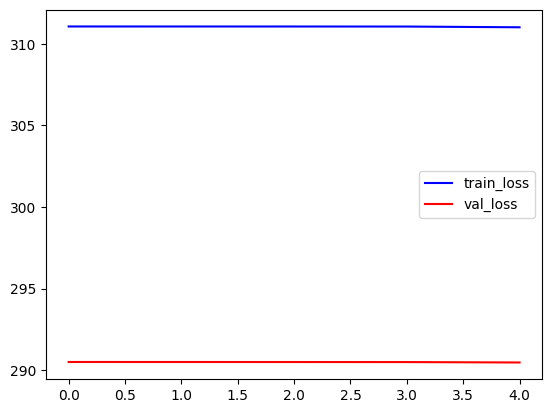

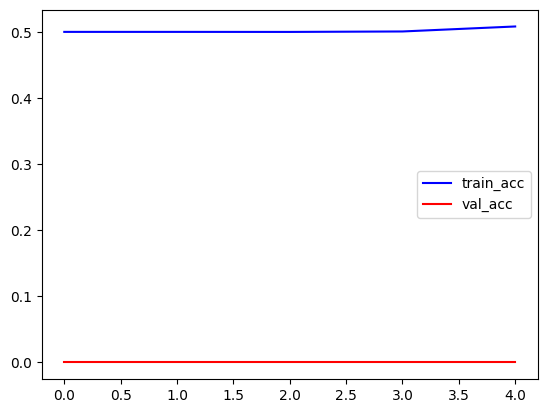

In [ ]:
#plot
x_axis = list(range(epoch))


plt.plot(x_axis, train_total_loss, "b", label="train_loss")
plt.plot(x_axis, val_total_loss, "r", label="val_loss")
plt.legend()
plt.show()

plt.plot(x_axis, train_total_acc, "b", label="train_acc")
plt.plot(x_axis, val_total_acc, "r", label="val_acc")
plt.legend()
plt.show()

In [ ]:
#semi-supervise learning